# cox univariant

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from lifelines import KaplanMeierFitter

import pickle
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter, KaplanMeierFitter, statistics
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold


#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import IterativeImputer
#from sklearn.ensemble import RandomForestRegressor




%load_ext autoreload
%autoreload 2

from configs import MIN_FEATURES


from survival_analysis_utils import cox_proportional_hazard_model


In [2]:

def prepare_data_to_model(proteomics_data):
    clinical_data = pd.read_csv("clinical_data_hadar.csv")
    print(f"Loading clinical data from {"clinical_data_hadar.csv"}\nShape: {clinical_data.shape}")
    
    clinical_data = clinical_data[["sample number", "Survival_from_onset (months)","Status dead=1", "Sex", "Disease Format", "ALSFRS score (unit)", "ALSFRS_group","Age Onset (years)"]]
    clinical_data.set_index("sample number", inplace=True)
    df_with_clinical = proteomics_data.join(clinical_data, how='inner')
    sex_mapping = {'M': 0, 'F': 1}
    df_with_clinical['Sex'] = df_with_clinical['Sex'].map(sex_mapping)
    disease_format_mapping = {'Limb': 0, 'Bulbar': 1}
    df_with_clinical['Disease Format'] = df_with_clinical['Disease Format'].map(disease_format_mapping)

    return df_with_clinical

## data after filtering


In [3]:
final_df = pd.read_csv("data_prossesing_final.csv").set_index('sample number')
final_df

,IGKV3-7,IGLV4-69,IGLV8-61,IGLV10-54,IGLV7-46,IGLV2-18,IGLV3-12,IGLV3-10,IGLV3-9,IGHV3-64,...,FHOD1,F11R,CPQ,EMILIN1,ROBO1,FCGBP,PCLO,COLEC10,APOA2_1,C1QA_1
sample number,,,,,,,,,,,,,,,,,,,,,
705,-10.204612,-10.677011,-10.371133,NaN,-10.386636,-10.708409,-10.775475,-10.387228,-10.398862,-10.477047,...,NaN,-10.670093,-10.439961,-10.899460,-10.745309,-10.248069,-10.350124,-10.367277,-10.838142,-10.920926
712,-10.261845,-10.631851,-10.553399,-11.033184,-10.423710,-10.553404,-10.781720,-10.423317,-10.412205,-10.730202,...,-10.850277,-10.657312,-10.422698,-10.950635,NaN,-10.267445,-10.381524,-10.393928,-10.631400,-10.930997
717,-10.181705,-10.596433,-10.329450,-10.801589,-10.347386,-10.586745,-10.618414,-10.385198,-10.328863,-10.465309,...,NaN,-10.709023,-10.448542,-10.910915,-10.743102,-10.216805,-10.298914,-10.361038,-10.591157,-10.895410
735,-10.201382,-10.620339,-10.525987,-10.974413,-10.394055,-10.628799,-10.773907,-10.424033,-10.409433,-10.614421,...,NaN,-10.686301,-10.396404,-10.994565,-10.704648,-10.234386,-10.388122,-10.370060,-10.699101,-10.765072
746,-10.315008,-10.890091,-10.478634,NaN,-10.518827,-10.726851,NaN,-10.535779,-10.430381,-10.614006,...,NaN,-10.662715,-10.436940,-10.940494,NaN,-10.255990,-10.448063,-10.373641,-10.813603,-10.790747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,-10.213779,-10.589771,NaN,-10.901073,-10.311487,-10.580031,-10.571975,-10.385638,-10.289457,-10.474354,...,NaN,-10.616867,-10.428219,NaN,-10.587708,-10.184392,-10.402729,-10.316921,NaN,-10.476288
1900,-10.154755,-10.651093,-10.311946,NaN,-10.368999,-10.833229,NaN,-10.562737,-10.423335,-10.521348,...,-10.845889,-10.566973,-10.405265,-10.918730,NaN,-10.219864,-10.382083,-10.324470,-10.680722,-10.440002
1912,-10.114605,-10.549059,-10.556772,-10.874781,-10.491286,-10.666894,-10.672145,-10.367900,-10.379130,-10.468953,...,NaN,-10.674030,-10.406008,-10.951507,-10.758552,-10.215317,-10.355471,-10.378270,-10.632625,-10.624632


## merge protein with clinical data

In [4]:
#merge will clinical data
data = prepare_data_to_model(final_df)
data

Loading clinical data from clinical_data_hadar.csv
Shape: (179, 19)


,IGKV3-7,IGLV4-69,IGLV8-61,IGLV10-54,IGLV7-46,IGLV2-18,IGLV3-12,IGLV3-10,IGLV3-9,IGHV3-64,...,COLEC10,APOA2_1,C1QA_1,Survival_from_onset (months),Status dead=1,Sex,Disease Format,ALSFRS score (unit),ALSFRS_group,Age Onset (years)
sample number,,,,,,,,,,,,,,,,,,,,,
705,-10.204612,-10.677011,-10.371133,NaN,-10.386636,-10.708409,-10.775475,-10.387228,-10.398862,-10.477047,...,-10.367277,-10.838142,-10.920926,40,1,0,0,41,4,73
712,-10.261845,-10.631851,-10.553399,-11.033184,-10.423710,-10.553404,-10.781720,-10.423317,-10.412205,-10.730202,...,-10.393928,-10.631400,-10.930997,55,1,0,0,43,5,63
717,-10.181705,-10.596433,-10.329450,-10.801589,-10.347386,-10.586745,-10.618414,-10.385198,-10.328863,-10.465309,...,-10.361038,-10.591157,-10.895410,5,1,0,0,37,4,70
735,-10.201382,-10.620339,-10.525987,-10.974413,-10.394055,-10.628799,-10.773907,-10.424033,-10.409433,-10.614421,...,-10.370060,-10.699101,-10.765072,9,1,0,0,34,4,65
746,-10.315008,-10.890091,-10.478634,NaN,-10.518827,-10.726851,NaN,-10.535779,-10.430381,-10.614006,...,-10.373641,-10.813603,-10.790747,5,1,0,1,44,5,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,-10.213779,-10.589771,NaN,-10.901073,-10.311487,-10.580031,-10.571975,-10.385638,-10.289457,-10.474354,...,-10.316921,NaN,-10.476288,80,0,0,0,39,4,64
1900,-10.154755,-10.651093,-10.311946,NaN,-10.368999,-10.833229,NaN,-10.562737,-10.423335,-10.521348,...,-10.324470,-10.680722,-10.440002,26,1,1,1,45,5,78
1912,-10.114605,-10.549059,-10.556772,-10.874781,-10.491286,-10.666894,-10.672145,-10.367900,-10.379130,-10.468953,...,-10.378270,-10.632625,-10.624632,48,0,0,0,40,4,55


In [5]:
pd.read_csv("clinical_data_hadar.csv") 

,sample number,ID,Birth year,Age Onset (years),Sex,12 Education years,Former athlete,Disease Format,diagn delay (months),Survival_from_onset (months),Status dead=1,ALSFRS score (unit),deltaFRS (-unit/months),Age at Collection (years),ALSFRS_group,deltaFRS_groups,DD_by_cat,Age_onset_cat,Survival_onset_cat
0,705,J30K59,1936,73,M,Below,No,Limb,12,40,1,41,0.583333,74,4,2.0,2,1,2
1,712,S20S79,1946,63,M,NaN,No,Limb,12,55,1,43,0.416667,64,5,3.0,2,2,3
2,717,L75U65,1939,70,M,Above,No,Limb,3,5,1,37,3.666667,71,4,1.0,1,2,1
3,735,B02E34,1944,65,M,Above,No,Limb,4,9,1,34,3.500000,66,4,1.0,1,2,1
4,746,F74V70,1972,37,M,Above,No,Bulbar,2,5,1,44,1.000000,38,5,2.0,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,1899,K01A78,1951,64,M,Below,No,Limb,41,80,0,39,0.214286,68,4,3.0,3,2,3
175,1900,B46B28,1941,78,F,Below,No,Bulbar,6,26,1,45,0.500000,78,5,3.0,1,1,1
176,1912,A90A55,1963,55,M,Below,No,Limb,1,48,0,40,1.600000,56,4,1.0,1,4,2
177,1913,H65G96,1948,70,F,Above,No,Limb,12,37,1,42,0.500000,71,4,3.0,2,2,2


### cox univariant - drop nan values - my code

In [6]:
####provide me 19 sig results


cox_p = {}
concordance_index = {}
hazard_ratios = {}


protein_names = [col for col in data.columns if col not in ['Status dead=1',  'Survival_from_onset (months)']]
for protein_name in protein_names:
    
    cox_data = data.dropna(subset=[protein_name])
    cph = cox_proportional_hazard_model(cox_data[[protein_name, 'Status dead=1',  'Survival_from_onset (months)']],
                                        'Survival_from_onset (months)',
                                        'Status dead=1',
                                        protein_name,
                                        strata=None,
                                        covariate_groups=None,
                                        show_plot=False)
    
    p_value = cph.summary.loc[protein_name]['p']
    c_index = cph.concordance_index_
    hazard_ratio = cph.hazard_ratios_[protein_name]

    cox_p[protein_name] = p_value
    concordance_index[protein_name] = c_index
    hazard_ratios[protein_name] = hazard_ratio

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'p_value': pd.Series(cox_p),
    'concordance_index': pd.Series(concordance_index),
    'hazard_ratio': pd.Series(hazard_ratios)
})

# Display the DataFrame
results_df






 Concordance index of the model 0.5409569053274517


 Concordance index of the model 0.4813299613210354


 Concordance index of the model 0.5330584597261081


 Concordance index of the model 0.5520129694677114


 Concordance index of the model 0.5419070240922973


 Concordance index of the model 0.5399823193763562


 Concordance index of the model 0.4841332804442681


 Concordance index of the model 0.5465897522904649


 Concordance index of the model 0.5212758737699356


 Concordance index of the model 0.5430277244029645


 Concordance index of the model 0.5028852920478536


 Concordance index of the model 0.49582985821517933


 Concordance index of the model 0.5334049409237379


 Concordance index of the model 0.5289446895147608


 Concordance index of the model 0.5031699858282986


 Concordance index of the model 0.4950118764845606


 Concordance index of the model 0.5041584158415842


 Concordance index of the model 0.5186969799796403


 Concordance index of the model 0.516185951

,p_value,concordance_index,hazard_ratio
IGKV3-7,0.474659,0.540957,0.575217
IGLV4-69,0.743204,0.481330,1.192438
IGLV8-61,0.652880,0.533058,0.759436
IGLV10-54,0.514602,0.552013,0.578473
IGLV7-46,0.531690,0.541907,0.644354
...,...,...,...
Sex,0.862140,0.498575,1.023128
Disease Format,0.370826,0.524499,1.144909
ALSFRS score (unit),0.125358,0.557686,0.985859
ALSFRS_group,0.175887,0.551340,0.910423


In [7]:
# Filter significant proteins
significant_proteins_df = results_df[results_df['p_value'] < 0.05]
significant_proteins_df

,p_value,concordance_index,hazard_ratio
MYO15B,0.020304,0.588531,8.471759
PDCD6,0.036533,0.576358,3.036478
OXSR1,0.007521,0.619709,12.590128
LMNA,0.042277,0.560484,5.946083
MT1E;MT1G;MT1M;MT1X;MT2A,0.038174,0.558276,4.072726
HSPB1,0.045703,0.555685,4.916228
CALM1;CALM2;CALM3,0.043209,0.577007,5.112464
KIF5B,0.036302,0.567381,4.693272
ALDH9A1,0.044872,0.572615,5.537585
EIF5A,0.019808,0.586928,6.154852


In [8]:
significant_proteins_df.shape

(19, 3)

In [9]:
significant_proteins_df = significant_proteins_df.reset_index()
significant_proteins_df

,index,p_value,concordance_index,hazard_ratio
0,MYO15B,0.020304,0.588531,8.471759
1,PDCD6,0.036533,0.576358,3.036478
2,OXSR1,0.007521,0.619709,12.590128
3,LMNA,0.042277,0.560484,5.946083
4,MT1E;MT1G;MT1M;MT1X;MT2A,0.038174,0.558276,4.072726
5,HSPB1,0.045703,0.555685,4.916228
6,CALM1;CALM2;CALM3,0.043209,0.577007,5.112464
7,KIF5B,0.036302,0.567381,4.693272
8,ALDH9A1,0.044872,0.572615,5.537585
9,EIF5A,0.019808,0.586928,6.154852


In [10]:
data

,IGKV3-7,IGLV4-69,IGLV8-61,IGLV10-54,IGLV7-46,IGLV2-18,IGLV3-12,IGLV3-10,IGLV3-9,IGHV3-64,...,COLEC10,APOA2_1,C1QA_1,Survival_from_onset (months),Status dead=1,Sex,Disease Format,ALSFRS score (unit),ALSFRS_group,Age Onset (years)
sample number,,,,,,,,,,,,,,,,,,,,,
705,-10.204612,-10.677011,-10.371133,NaN,-10.386636,-10.708409,-10.775475,-10.387228,-10.398862,-10.477047,...,-10.367277,-10.838142,-10.920926,40,1,0,0,41,4,73
712,-10.261845,-10.631851,-10.553399,-11.033184,-10.423710,-10.553404,-10.781720,-10.423317,-10.412205,-10.730202,...,-10.393928,-10.631400,-10.930997,55,1,0,0,43,5,63
717,-10.181705,-10.596433,-10.329450,-10.801589,-10.347386,-10.586745,-10.618414,-10.385198,-10.328863,-10.465309,...,-10.361038,-10.591157,-10.895410,5,1,0,0,37,4,70
735,-10.201382,-10.620339,-10.525987,-10.974413,-10.394055,-10.628799,-10.773907,-10.424033,-10.409433,-10.614421,...,-10.370060,-10.699101,-10.765072,9,1,0,0,34,4,65
746,-10.315008,-10.890091,-10.478634,NaN,-10.518827,-10.726851,NaN,-10.535779,-10.430381,-10.614006,...,-10.373641,-10.813603,-10.790747,5,1,0,1,44,5,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,-10.213779,-10.589771,NaN,-10.901073,-10.311487,-10.580031,-10.571975,-10.385638,-10.289457,-10.474354,...,-10.316921,NaN,-10.476288,80,0,0,0,39,4,64
1900,-10.154755,-10.651093,-10.311946,NaN,-10.368999,-10.833229,NaN,-10.562737,-10.423335,-10.521348,...,-10.324470,-10.680722,-10.440002,26,1,1,1,45,5,78
1912,-10.114605,-10.549059,-10.556772,-10.874781,-10.491286,-10.666894,-10.672145,-10.367900,-10.379130,-10.468953,...,-10.378270,-10.632625,-10.624632,48,0,0,0,40,4,55


#### Kaplan–Meier estimator for significant proteins

In [11]:
protein_medians = data.median()
protein_medians

IGKV3-7               -10.197222
IGLV4-69              -10.626069
IGLV8-61              -10.407996
IGLV10-54             -10.901083
IGLV7-46              -10.386636
                         ...    
Sex                     0.000000
Disease Format          0.000000
ALSFRS score (unit)    39.000000
ALSFRS_group            4.000000
Age Onset (years)      61.000000
Length: 1592, dtype: float64

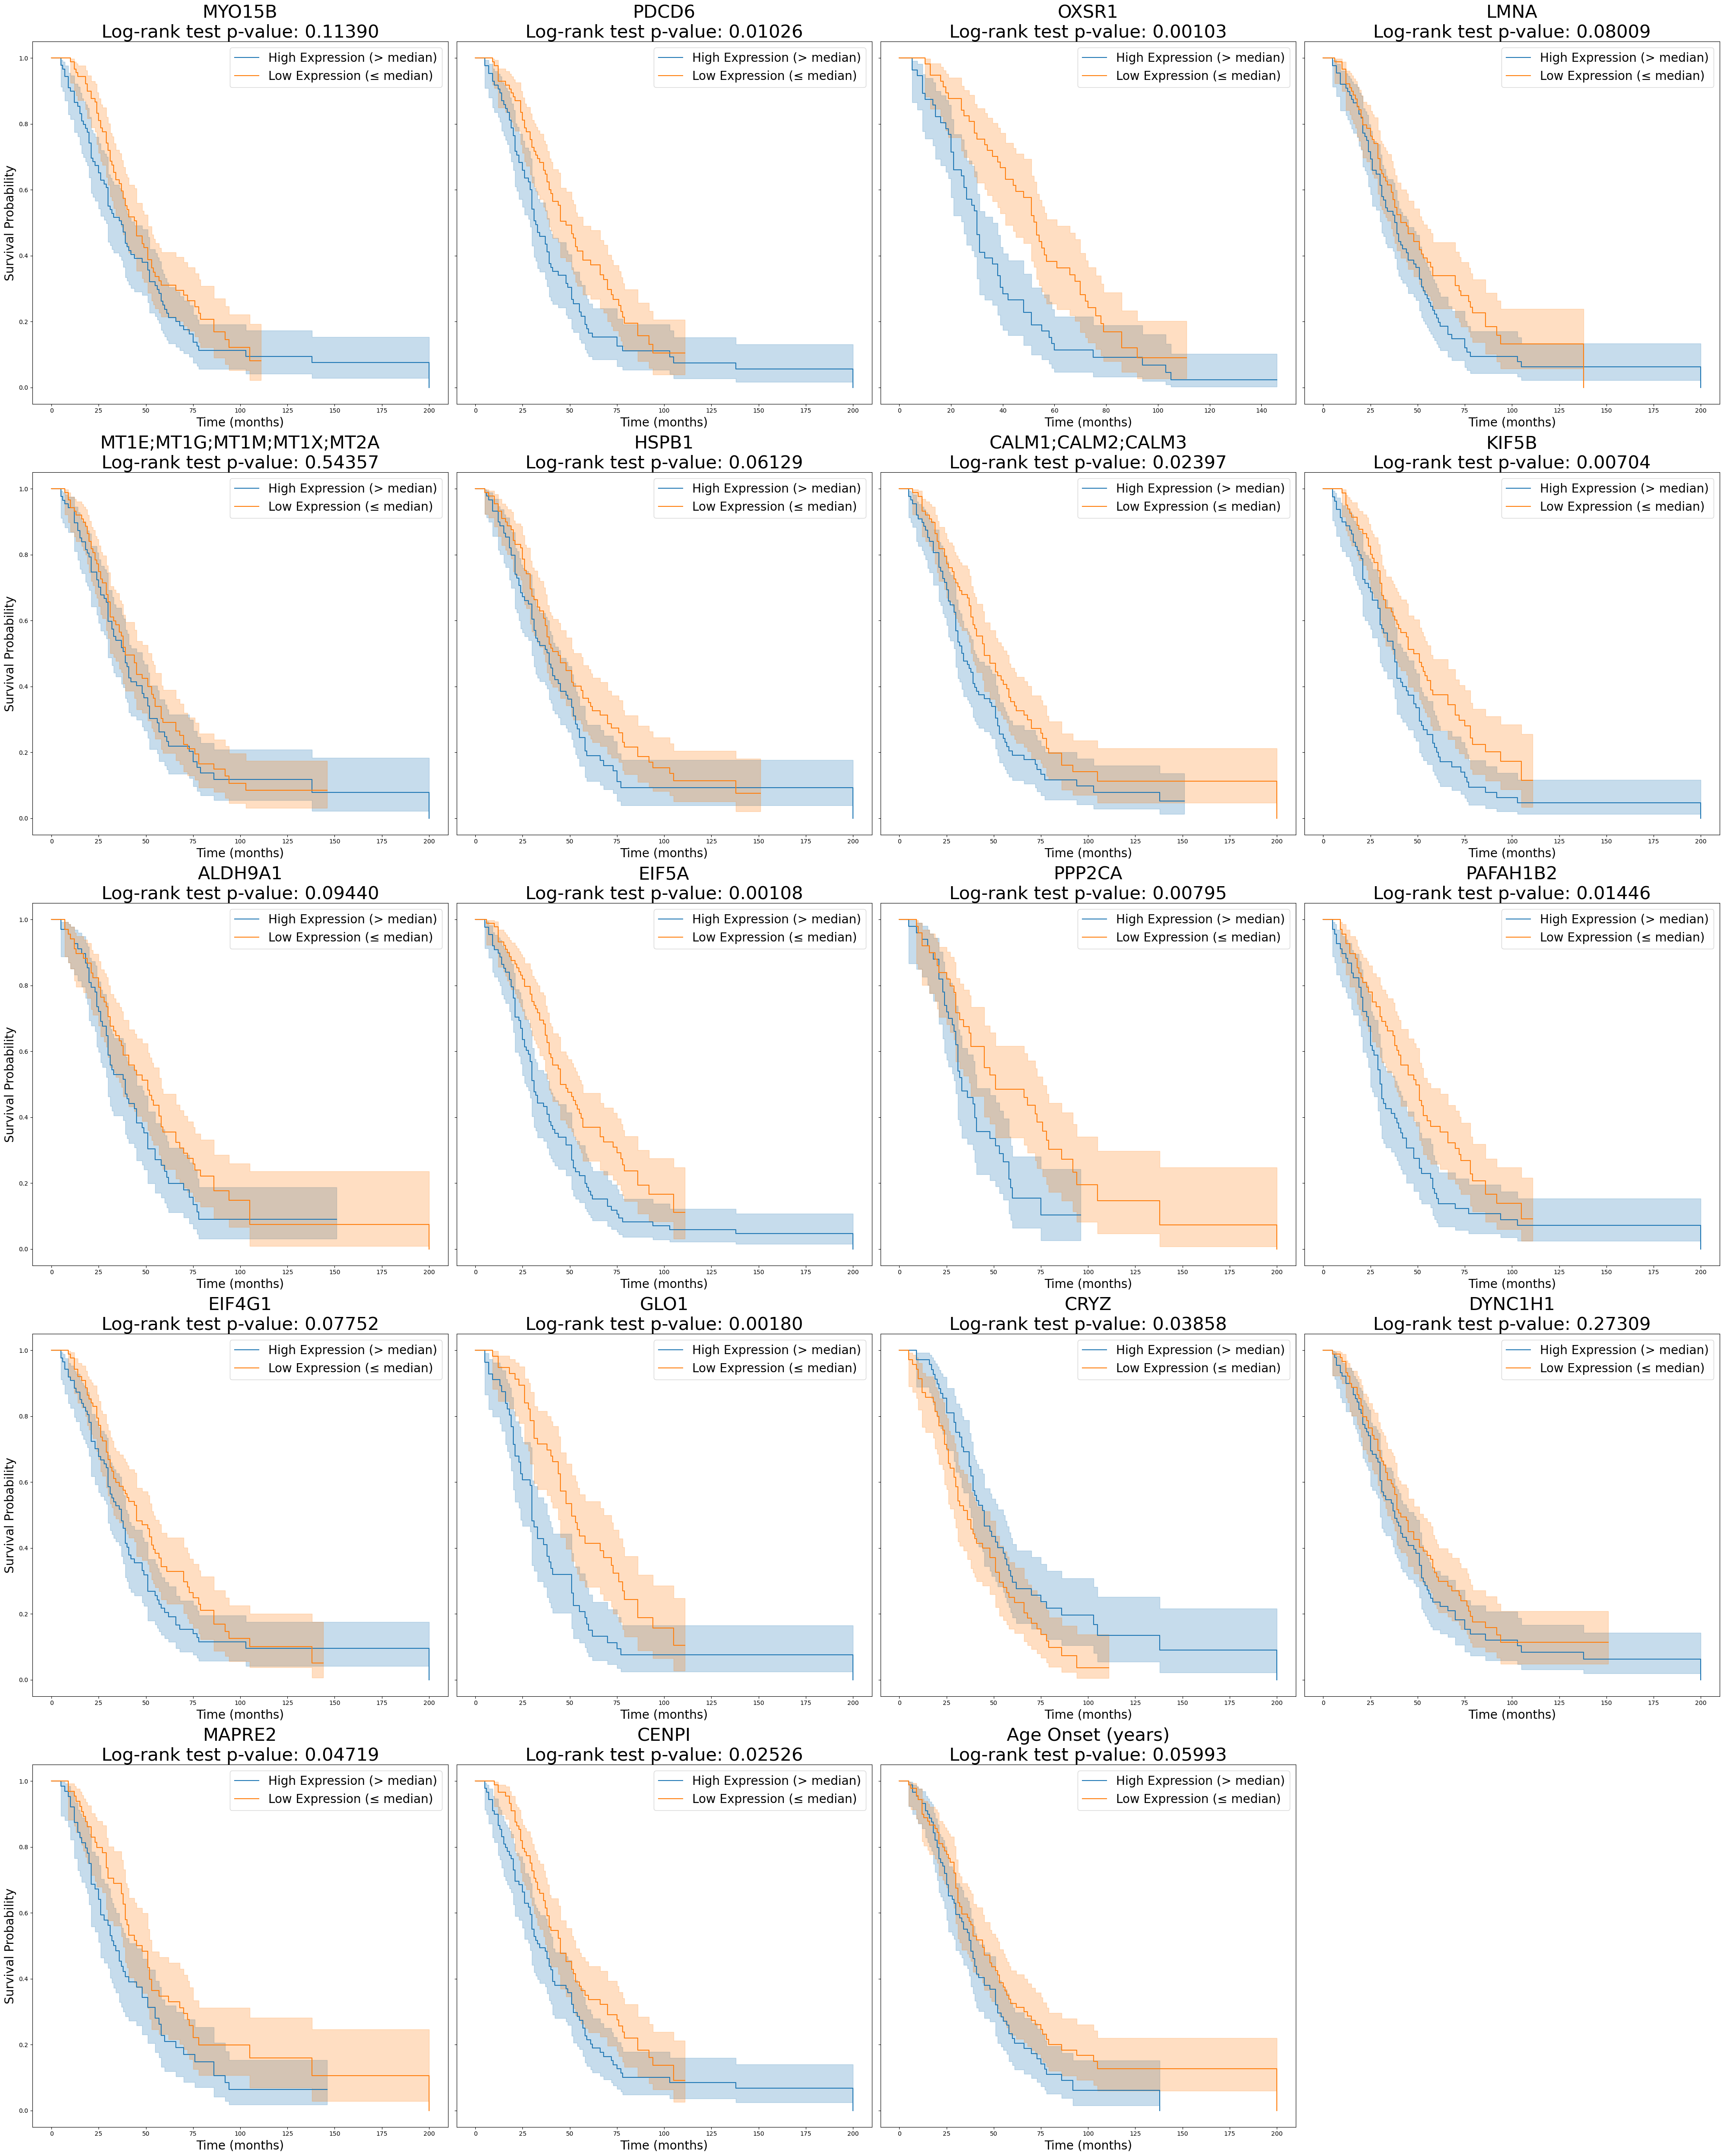

In [18]:

kmf = KaplanMeierFitter()
num_proteins = len(MIN_FEATURES)
num_cols = 4
num_rows = (num_proteins + num_cols - 1) // num_cols  # Calculate the number of rows needed

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols * 10, num_rows * 10), sharey=True)
axes = axes.flatten()  # Flatten the axes array for easy iteration

for i, protein in enumerate(MIN_FEATURES):
    ax = axes[i]
    
    # Create high and low expression groups based on the median
    median_threshold = data[protein].median()
    
    # Only consider the high and low groups
    high_group = data[data[protein] > median_threshold]
    low_group = data[data[protein] <= median_threshold]
    
    # Calculate the log-rank test p-value
    result = statistics.logrank_test(high_group['Survival_from_onset (months)'], 
                                     low_group['Survival_from_onset (months)'], 
                                     event_observed_A=high_group['Status dead=1'], 
                                     event_observed_B=low_group['Status dead=1'])
    p_value = result.p_value
    
    # Plot high expression group
    kmf.fit(durations=high_group['Survival_from_onset (months)'], 
            event_observed=high_group['Status dead=1'], 
            label='High Expression (> median)')
    kmf.plot_survival_function(ax=ax)
    
    # Plot low expression group
    kmf.fit(durations=low_group['Survival_from_onset (months)'], 
            event_observed=low_group['Status dead=1'], 
            label='Low Expression (≤ median)')
    kmf.plot_survival_function(ax=ax)
    
    ax.set_title(f'{protein}\nLog-rank test p-value: {p_value:.5f}', fontsize=30)
    ax.set_xlabel('Time (months)', fontsize=20)
    if i % num_cols == 0:
        ax.set_ylabel('Survival Probability', fontsize=20)
    ax.legend(fontsize=20)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
